# Real Time Embedded Systems (ECE-GY 6483)
## Embedded Challenge Spring 2021

### Introduction
In this notebook, I will calculate the Heart rate, Systolic and Diastolic blood pressure from the cuff pressure readings. I am using the STM32 Discovery board, Honeywell MPRLS0300YG00001BB pressure sensor and a blood pressure cuff. The readings are taken once every 20ms. The pressure is raised to 200mmHg and is decreased gradually while we get all the useful data from 150-80. I am reading this data from the serial from the python in Vscode instead of copying the data from serial print. This gives me some flexibility in the algorithm to extract the Systolic and Diastolic blood pressures. The rest of this code could have be done in Vscode but for a project demonstration clear representation of data is important so I wrote the data into text file and exported to Colab.

## Importing libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import plotly.graph_objects as go
from matplotlib import pyplot
import scipy.signal

## Pressure data visualization

Data is submitted in the zip file for reference. I have collected the raw data from serial and applied the transfer function in the code below. Since the pressure reading is taken manually I am considering 500 samples after pressure reaches a maximum value which has all the data we need for calculating the required values.

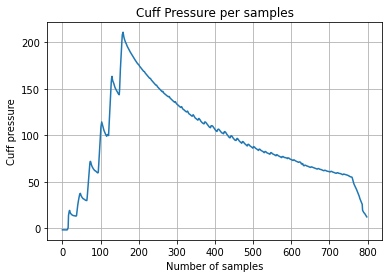

In [ ]:
# Read the data in .txt file
with open('pressure_data.txt') as f:
  for line in f:
    line = line[1:-1]
line = line.replace("'",'')
line = line.replace(" ",'')

# Split the data as the data is in string format
line = line.split(',')

# Converting outpt values to pressure as per data sheet
data = [((float(i)-419430.4)*300)/(3774873.6-419430.4) for i in line]

# Considering 500 samples from peak which has all the data required
low_lim = data.index(max(data))+100
up_lim = low_lim + 500
Focus_data = data[low_lim:up_lim]
plt.plot(data)
plt.xlabel('Number of samples')
plt.ylabel('Cuff pressure')
plt.title('Cuff Pressure per samples')
plt.grid()
plt.show()

## Detrending the data

In this part of the code, we take the Focus_data detrend the signal and plot the graph. In data detrending, the linear trend is removed along the axis from data ("scipy.signal.detrend") giving us a clean waveform with constant frequency. Here, we also get the peaks as we use them to calculate the heart rate. 

In [ ]:
# Getting the peaks by detrending the focussed data
X = Focus_data
diff = list()
for i in range(1, len(X)):
	value = X[i] - X[i - 1]
	diff.append(value)
ffty=scipy.signal.detrend(diff,type = 'linear')
indices = find_peaks(ffty,distance=13)[0]

# Plotting the Detrended data
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=ffty,
    mode='lines+markers',
    name='Original Plot'
))

# Getting the peak values to measure heart rate
Peak_vals = [ffty[j] for j in indices]

# Plotting the peak values
fig.add_trace(go.Scatter(
    x=indices,
    y=Peak_vals,
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks',
))
fig.update_layout(
    title={
        'text': "Cuff pressure changes used to calculate blood pressure",
        'y':0.9,
        'x':0.5},
    xaxis_title = 'Number of samples',
    yaxis_title = 'Pressure within cuff during each beat',
    font=dict(
    family="Courier New, monospace",
    size=14,
    color="black"
)
)
fig.show()

## Systolic and Diastolic pressure

Here, we calculate Systolic and Diastolic blood pressure by taking the Mean Arterial Pressure (MAP). Systolic being 50% of MAP frequency and diastolic being 80% of MAP. We then plot them on the acquired pressure data.

The pressure value (Sys/Dias) is  125.28505325317383 / 88.75953555107117 


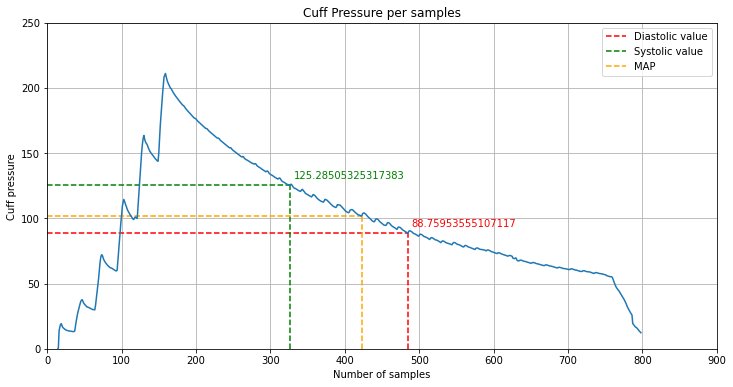

In [ ]:
# Calculating the Systolic and Diastolic pressure by taking Mean Arterial Pressure
ffty = list(ffty)
MAP = max(ffty)
Map_Index = low_lim + ffty.index(MAP)
Map_Val = data[Map_Index]

#Considering the Diastolic Coefficient
temp = 0.8*MAP
absolute_difference_function = lambda list_value : abs(list_value - temp)
closest_value = min(Peak_vals[Peak_vals.index(MAP):], key=absolute_difference_function)
Dias_Index = low_lim + ffty.index(closest_value)
Dias_Val = data[Dias_Index]

#Considering the Systolic Coefficient
temp = 0.5*MAP
absolute_difference_function = lambda list_value : abs(list_value - temp)
closest_value = min(Peak_vals[:Peak_vals.index(MAP)], key=absolute_difference_function)
Sys_Index = low_lim + ffty.index(closest_value)
Sys_Val = data[Sys_Index]

print('The pressure value (Sys/Dias) is','\033[1m',Sys_Val,'/',Dias_Val, '\033[0m')

# Plotting all the data on graph
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data)
ax.vlines(Dias_Index, 0, Dias_Val, linestyles='dashed', colors='red',label='Diastolic value')
ax.hlines(Dias_Val, 0, Dias_Index, linestyles='dashed', colors='red')
ax.vlines(Sys_Index, 0, Sys_Val, linestyles='dashed', colors='green',label='Systolic value')
ax.hlines(Sys_Val, 0, Sys_Index, linestyles='dashed', colors='green')
ax.vlines(Map_Index, 0, Map_Val, linestyles='dashed', colors='orange',label='MAP')
ax.hlines(Map_Val, 0, Map_Index, linestyles='dashed', colors='orange')
ax.annotate(str(Sys_Val), xy =(Sys_Index + 5, Sys_Val + 5),xytext =(Sys_Index + 5, Sys_Val + 5), color = 'green'   )
ax.annotate(str(Dias_Val), xy =(Dias_Index + 5, Dias_Val + 5),xytext =(Dias_Index + 5, Dias_Val + 5), color='red'  )

plt.xlabel('Number of samples')
plt.ylabel('Cuff pressure')
plt.title('Cuff Pressure per samples')
# Setting the limits
plt.xlim(0,900)
plt.ylim(0,250)
plt.legend()
ax.grid()
plt.show()

## Heart rate

We then calculate the heart rate in beats per minute. From using the timer using vscode, I can see that we get a sample every 23.57ms (20ms intended) because of the delay caused by other operations. I took 5 peaks and the distance between them and multiplied by 60 to calculate the number of beats per minute.

In [ ]:
# Calculating the Heart rate by calculating the average of 10 peaks
peak_distance = indices[Peak_vals.index(MAP)+3]-indices[Peak_vals.index(MAP)-3]
num_of_peaks = 5
time_per_sample = 0.02357 # Obtained from using timer in VScode
Heart_rate = (num_of_peaks*60)/(peak_distance*time_per_sample)
print('The Heart rate is',Heart_rate,'bpm')

The Heart rate is 128.56610226147774 bpm
